<a href="https://colab.research.google.com/github/YusolCho/NLPstudy/blob/main/NLP_DACON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이콘 소설 작가 분류 AI 경진대회**
### OBJECT : 문체 분석 알고리즘 개발 

In [23]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# regex
import re

# stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# tokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TreebankWordTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Vectorizer
import gensim
import urllib.request #*********
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

#DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input

#scoring
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [24]:
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/train.csv'
data = pd.read_csv(filename,delimiter=',')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [25]:
data.shape 

(54879, 3)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   54879 non-null  int64 
 1   text    54879 non-null  object
 2   author  54879 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [82]:
data.author.describe()

count    54879.000000
mean         1.944988
std          1.391632
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: author, dtype: float64

In [5]:
del data['index']
data.head()

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [7]:
pd.set_option('max_colwidth', 200)
data.head()

,text,author
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3


# **EDA**
- 참고 : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

## **1. Analyzing Text Statistics** 
- Content
1. word frequency analysis
2. sentence length analysis
3. average word length analysis
4. etc

- 히스토그램 등으로 시각화하면서 특성 파악 

- 우선, 각각의 text 의 길이를 알아보자(text length analysis)

Text(0.5, 1.0, 'Text Length')

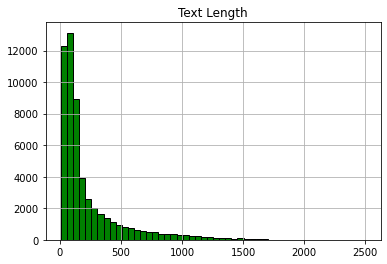

In [32]:
data['text'].str.len().hist(bins=50, histtype='bar', color='g', edgecolor='k')
plt.title('Text Length')

- 0~1800 사이에 분포하며 대부분 0-250 에 포함된다
- 0-250을 확대해서 확인해보자 

Text(0.5, 1.0, 'Text Length in 0-500')

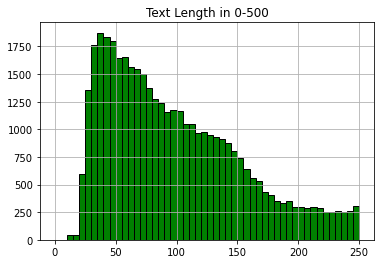

In [36]:
data['text'].str.len().hist(bins=50, range=[0, 250], histtype='bar', color='g', edgecolor='k')
plt.title('Text Length in 0-500')

- 각 텍스트는 보통 30-150의 길이이다.

- 다음으로 word-level 에서 EDA(텍스트별 어절 개수)
- plot the number of words appearing in each text 

Text(0.5, 1.0, 'number of words in each text(based on spaces)')

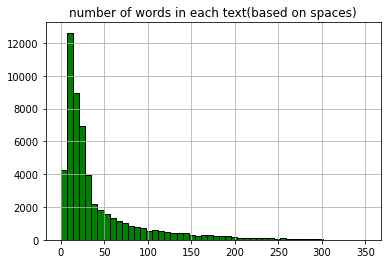

In [43]:
# data['text'].str.split().map(lambda x: len(x)).hist(bins=50, range=[0, 350], histtype='bar', color='g', edgecolor='k')
# plt.title('number of words in each text(based on spaces)')
# 띄어쓰기 기준으로 단어개수 count 한거라 부정확할 수 있다. 
# 띄어쓰기를 기준으로 하면 대충 7-28개의 단어가 한 text에 있다고 볼 수 있음 
# text 길이가 짧을 때 사용하는 게 나을듯 


- 그 다음으로 각 text 에서 사용된 단어들의 평균 길이를 살펴본다.
- 근데 이 과정이 왜 필요한지 모르겠음.. 어따쓰는경

Text(0.5, 1.0, '')

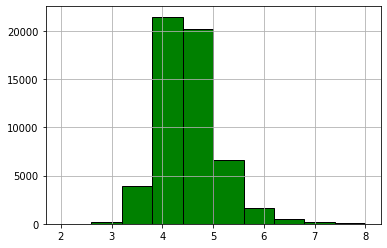

In [50]:
data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(range = [2,8], color='g', edgecolor='k')
plt.title('')
#data의 text변수를 space를 기준으로 split하고 난 뒤 그 length를 apply(lambda)를 통하여 새롭게 계산하고, 계산 한 값을 map(lambda)함수를 통해 

- 그래프를 통해, 3-6정도 길이의 짧은 단어를 평균적으로 사용하고 있음을 알 수 있다. 
- 약간 right-skewed
- 이 부분은 나중에 불용어처리를 하고 나서 다시 확인해볼 것 
- 불용어(stopword; 전치사, 관사 등 대부분 짧은 길이)때문에 짧게 측정되었을 가능성 다분

##### cf) apply(lambda x:) 코드의 용도
- 노이즈 제거할 때처럼, '복잡한 필터링을 하고 싶은 경우에 사용되는 코드이다. 
- https://wikidocs.net/46758 이 사이트 참고하기 
- 기본 구조 : 
> DataFrame명.apply(lambda x : x['칼럼명']들의 조건식 
>                            if x['칼럼명']들의 조건식 
>                            else (x['칼럼명']들의 조건식 또는 값), axis = 1)



##### **cf) map(lambda x:)코드의 용도** 
- apply(lambda x:)와 상당히 유사함 
- lambda함수는 map함수와 연결하여 자주 사용됨
- map함수는 map(함수, 반복가능한 자료형)형태로 어떤 함수와 반복가능한 자료형(주로 리스트와 같은)을 입력변수로 받음. 
- 예)
- a = map(lambda x : x * 2 , [1,2,3,4])
- list(a)
- [2,4,6,8]

##### **먼저 lambda 문법을 알 필요가 있음**
- https://wikidocs.net/47806 참고 
- lambda 함수 :사용자정의 함수보다 훨씬 간단하게 한줄 정도로 해결할 수 있는 함수
- 문법 : lambda <매개변수1>, <매개변수2>...  : 매개변수를 이용한 식(if 문이 나올 수 있음)
- 예)
- f = lambda x, y : x + y
- f(5,6)
- 11

- 다음으로, 코퍼스 전체(모든 text)에서 가장 많이 사용되는 stopwords들은 어떤 건지  살펴보자

In [55]:
# 이 코드가 잘 이해되지 X 

# 전체 코퍼스에서 불용어 종류별로 그 개수 count 하는 함수 정의 
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))#stop변수에 nltk의 영어 stopwords 저장 
    
    new= data['text'].str.split() #띄어쓰기 기준으로 쪼개고
    new=new.values.tolist() #그 결과를 리스트로(?)
    corpus=[word for i in new for word in i] #뭐라는거야
    from collections import defaultdict
    dic=defaultdict(int) #정수 딕셔너리화(?)이거 이후로 뭔소린지...^ 
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

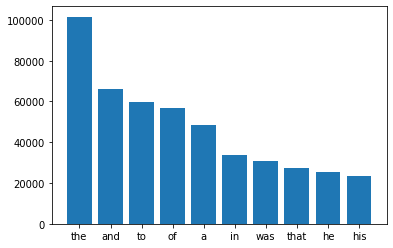

In [56]:
plot_top_stopwords_barchart(data['text'])

- 역시나 관사 전치사 대명사 등이 많다 
- 특히 the, and, to가 많이 사용되었음

- 그 외 다른 불용어들도 확인해보자 

In [64]:
import collections

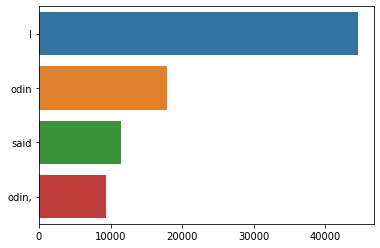

In [66]:
counter=collections.Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

- 특이하게도 said 와 odin 그리고 odin, 이 자주 사용되었다.
- 이 단어들을 포함한 행들을 추출해보자

In [75]:
data[data['text'].str.contains('said', na = False)]

,text,author
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
5,"""It was well fought,"" he said, ""and, by my sooth, they will not charge us twice.""",4
7,"“A proper figure of a man at-arms,” said the little knight. “Why, man, you are no chicken, yet I warrant him the stronger man. See to that great stone from the coping which hath fodin upon the bri...",2
8,"'You were not here last Sunday night,' he said.",0
14,“Have you no friends?” said I.,4
...,...,...
54864,"He appeared presently, looking a little irritable at being disturbed in his slumbers. “I made my report at the office,” he said.",1
54865,"“I am going,” she said again, in a gentler voice, “to be married to him. The preparations for my marriage are making, and I shall be married soon. Why do you injuriously introduce the name of my m...",0
54869,"'You are afraid, Brittles,' said Mr. odin.",0
54871,"“Sir odin will have great cause to thank you,” said the Prince.",4


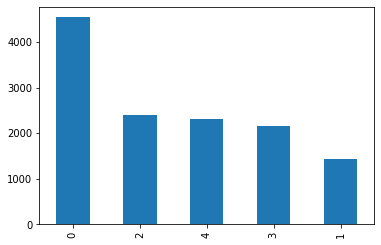

In [76]:
data_said = data[data['text'].str.contains('said', na = False)]

# author 별로 said 포함 데이터 개수 그래프로 그리기 
# Plot 
import matplotlib.pyplot as plt

#value_counts() : 기본적으로 지정된 열의 각 값(value)에 대한 모든 발생횟수를 반환
#.plot():pandas 내장 
data_said['author'].value_counts().plot.bar()

- 0번 작가의 글에서 said 가 많이 등장했음을 알 수 있다. 
- 위의 said 가 들어간 데이터 중에서 author=0만 따로 추출하고 살펴보자 

In [77]:
data_said.loc[data_said.author == 0]

,text,author
8,"'You were not here last Sunday night,' he said.",0
19,"‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable...",0
36,"“Why, yes,” said Mr. odin. “I know the moves of it.”",0
43,"“Yes,” said a voice from the darkness beneath.",0
54,"'It's done in a minute,' said odin, in the same low whisper. 'Directly I leave go of you, do your work. Hark!'",0
...,...,...
54847,"'Come in, come in,' said the old lady: 'I knew we should hear of him. Poor dear! I knew we should! I was certain of it. Bless his heart! I said so all along.'",0
54862,"‘That’s Missis odin,’ said Mr. odin.",0
54865,"“I am going,” she said again, in a gentler voice, “to be married to him. The preparations for my marriage are making, and I shall be married soon. Why do you injuriously introduce the name of my m...",0
54869,"'You are afraid, Brittles,' said Mr. odin.",0


- 0번 작가는 "(인용문)", said 인물  이 구조를 상당히 많이 사용하는 듯 하다. 그래서 said 라는 불용어 사용 빈도가 높다. 

In [80]:
data_said.loc[data_said.author == 3]

,text,author
30,"""I won't give up odin to you,"" he said. odin started. They looked at one another.",3
39,"“I did not expect you,” he said, hurriedly, with a look that made her stop. “Please sit down. You come, no doubt, from odin. Allow me--not there. Sit here....”",3
60,"“I am not laughing, odin; I am only listening with all my attention,” said Totski, with dignity.",3
82,"""You called her that yourself just now,"" said odin growing a little bolder. ""And I dreamed of a beauty like that,"" she added, laughing, as it were accidentally.",3
89,"“No, no; it’s all right, come in,” said Parfen, recollecting himself.",3
...,...,...
54762,"“Listen to me! You are going to live here, are you not?” said odin. “I mean to get something to do directly, and earn money. Then shall we three live together? You, and I, and odin? We will hire a...",3
54770,"“What will our peasants say now?” said one stout, cross‐looking, pock‐ marked gentleman, a landowner of the neighborhood, approaching a group of gentlemen engaged in conversation.",3
54791,"“Of course it is all, my friend. I don’t doubt you for a moment,” said odin with dignity.",3
54849,"As for Stepan odin's son, he had only seen him twice in his life, the first time when he was born and the second time lately in odin, where the young man was preparing to enter the university. The...",3


- 엄 근데 저런식으로 said 포함 텍스트들 중 다른 작가들의 것도 한번씩 봐봤는데... 그냥 전체적으로 "(인용문)", said 인물 이 구조를 많이 사용함. 아무래도 소설류이다 보니 그런듯. 

- 그냥 0번작가의 text 데이터 개수가 많은 건 아닌지?


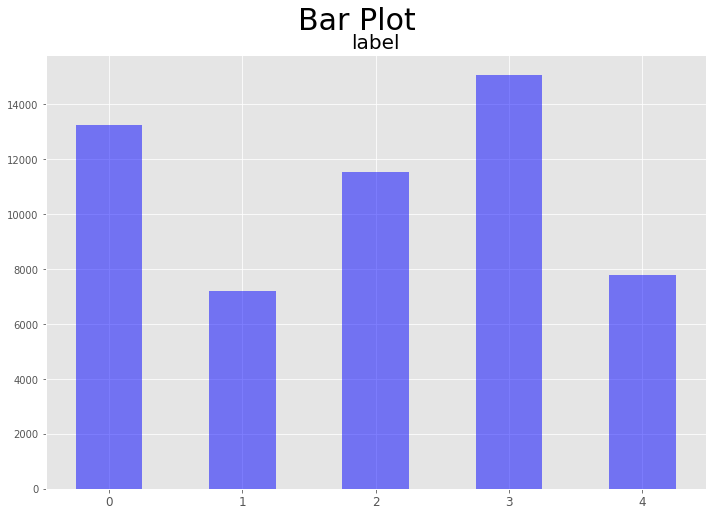

In [48]:
%matplotlib inline
plt.style.use("ggplot")

# 히스토그램 을 사용해서 데이터의 분포를 살펴보기.
feature = data['author']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정
plt.suptitle("Bar Plot", fontsize=30) # 부제목과 폰트 크기 설정

plt.title('label', fontsize=20) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

- 0번 작가의 데이터 개수가 막 특히나 많은 건 아니었고,
- 그러면 하나의 데이터의 텍스트 길이 평균이 큰건가 

In [41]:
data_0 = data.loc[data.author == 0]

data_1 = data.loc[data.author == 1]

data_2 = data.loc[data.author == 2]

data_3 = data.loc[data.author == 3]

data_4 = data.loc[data.author == 4]

In [55]:
print(np.mean(data_0['text'].str.len()))
print(np.mean(data['text'].str.len()))


193.83422742727618
219.51276444541628


- 오히려 작가 0은 한 데이터당 텍스트길이가 짧은 편. 




In [106]:
type(data.text)

pandas.core.series.Series

## **Ngram 탐색**

In [108]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
  



- bigram

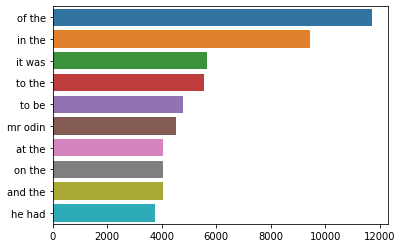

In [5]:
plot_top_ngrams_barchart(data['text'],2)

- 유의미한거 안나옴.. 볼만한 건 그냥 mr odin 정도

- trigram

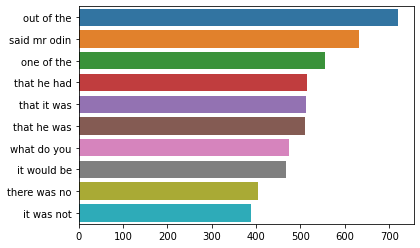

In [7]:
plot_top_ngrams_barchart(data['text'],3)

- 역시나 said mr odin 이 자주 등장. 여기서도 딱히 볼만한 건 없는듯.
- 아무래도 불용어가 많아서 그런 것 같으니 나중에 불용어 제거 하고 다시 ㄲ 
- 아무래도 전치사, 대명사, 관사 등등 다 제외시켜야할듯. 살릴만한 건 거의 없음 

- 전처리 시작하기 전에 간단하게 워드 클라우드 만들어서 확인하기 

In [38]:
# Code Snippet for Wordcloud

from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


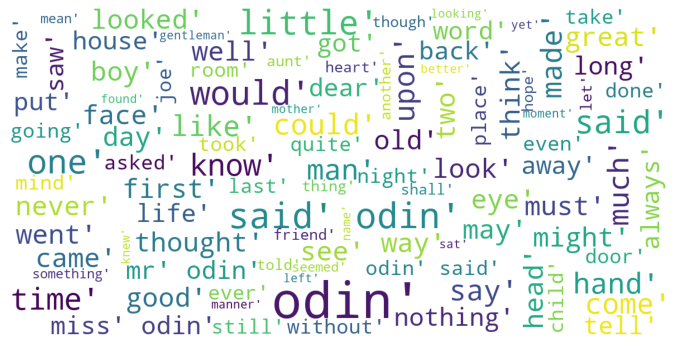

In [42]:
plot_wordcloud(data_0['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


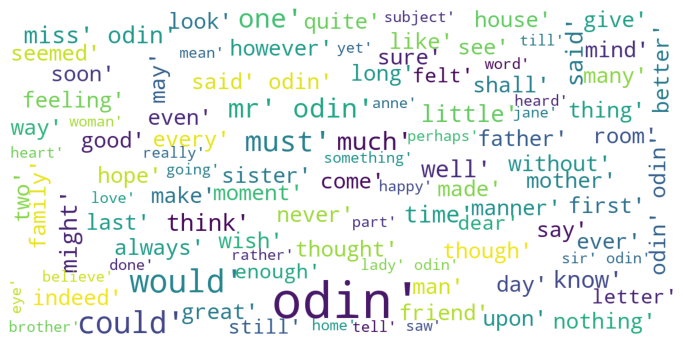

In [46]:
plot_wordcloud(data_1['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


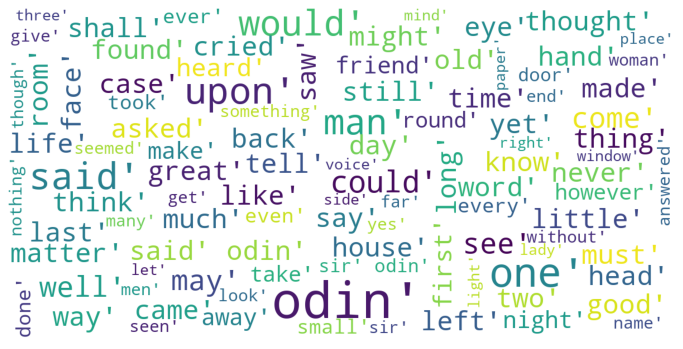

In [45]:
plot_wordcloud(data_2['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


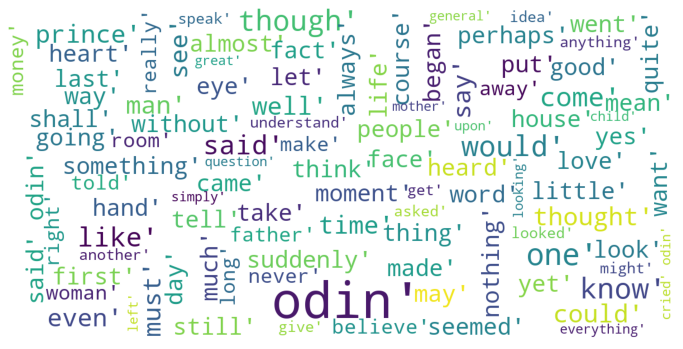

In [44]:
plot_wordcloud(data_3['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


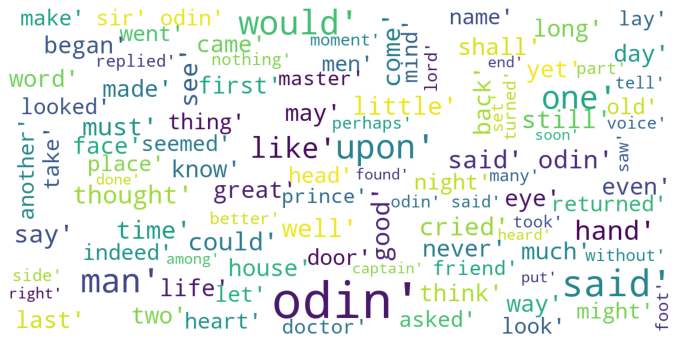

In [43]:
plot_wordcloud(data_4['text'])

#### 음...^^결과가 별로인 거 같음 
#### 불용어 제거하고, 명사만 따로 추출해서 다시 워드 클라우드 만들어보자 

## **전처리**

## **노이즈제거**

In [49]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    review = re.sub(r'"+', ' ', review) #spaces 제거
    review = re.sub('[^a-zA-Z]', ' ', review)    
    
    corpus.append(review) 
  
  return corpus

- 냅다 소문자 변환 해버리긴 했는데 좀 더 정교한 방법이 있나 찾아보는 게 좋을 것 같다. 

In [50]:
temp = clean_text(data['text']) #메소드 적용
data['text'] = temp
data.head(20)
data.tail(20)

,index,text,author
54859,54859,odin looked at him in silence,3
54860,54860,certainly i will be so good gentlemen,3
54861,54861,her mind made up on these several points and h...,1
54862,54862,that s missis odin said mr odin,0
54863,54863,well if it was my house i should never sit any...,1
54864,54864,he appeared presently looking a little irritab...,1
54865,54865,i am going she said again in a gentler voice t...,0
54866,54866,we clambered up through the hole odin turned h...,2
54867,54867,my dear odin you are talking quite idly pray w...,1
54868,54868,the young gentleman smiled as if to intimate t...,0


In [58]:
# 영문 텍스트 데이터 전처리 함수
#def preprocessing(review, remove_stopwords = False):
#    #불용어 제거는 선택이 가능하도록
#    
#    # HTML 태그 제거
#    review_text = BeautifulSoup(review, "html5lib").get_text()
#    
#    # 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
#    review_text = re.sub("[^a-zA-Z]"," ", review_text)
#    
#    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트화
#    words = review_text.lower().split()
#    
#    if remove_stopwords:
#        # 불용어 제거
#        
#        # 영어 불용어 사전 불러오기
#        stops = set(stopwords.words("english"))
#        stops.append('said')
#        stops.append('odin')
#        # 불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
#        words = [w for w in words if not w in stops]
#        # 단어 리스트를 하나의 글로 합성
#        clean_review = ' '.join(words)
#        
#    else: # 불용어 제거 옵션이 안 걸렸을시
#        clean_review = ' '.join(words)
#        
#    return clean_review

## 토큰화

In [61]:
word_tokens = nltk.word_tokenize((data.text)) 

TypeError: ignored

- 그냥 토큰화하니까 에러뜸 
- string이나 bytes-like object로 바꾸래...
- TypeError: expected string or bytes-like object

- 데이터프레임에 담겨져 있는 걸 문자열 형태로 바꿔주기 위해, 다음과 같은 함수를 새로 정의

In [62]:
def df2str(df):
    
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

- 다시 토큰화를 실행시켜보자 

In [63]:
word_tokens = nltk.word_tokenize(df2str(data.text)) 

In [66]:
word_tokens[0]

'he'

In [69]:
print(type(word_tokens))

<class 'list'>


- 토큰화 성공! 

## **Stopwords 처리하기**
- nltk 불용어 사전 사용 

In [70]:
#stopwords_list에 nltk 의 english 불용어들 저장 
stopwords_list = stopwords.words('english') #nltk에서 제공하는 불용어사전 이용
print('stopwords: ', stopwords_list)

stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

- NLTK 에서 지정한 stopwords 이외에도, 앞서 said, odin 이 자주 사용된 것을 확인하였다. 
- 이는 모든 작가들에게서 나타나는 공통특징, 분류에 도움을 주지 않으므로 삭제한다. 
- stopwords_list에 say, odin 을 추가한다. 

In [71]:
stopwords_list.append('say')

In [72]:
stopwords_list.append('odin')

In [112]:
stopwords_list.append('said')

In [113]:
result = []
for token in word_tokens: 
    if token not in stopwords_list: 
        result.append(token) 

In [114]:
type(result)

list

In [115]:
print(result[0:20])

['almost', 'choking', 'much', 'much', 'wanted', 'strange', 'exclamations', 'came', 'lips', 'pole', 'gazed', 'fixedly', 'bundle', 'notes', 'hand', 'looked', 'evident', 'perplexityyour', 'sister', 'asked']


- 불용어 제거 완료 

In [116]:
wnlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in result:
    new_word = wnlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [117]:
type(lemmatized_words)

list

In [118]:
lemmatized_words[0:10]

['almost',
 'choking',
 'much',
 'much',
 'wanted',
 'strange',
 'exclamation',
 'came',
 'lip',
 'pole']

In [119]:
#Exploration 을 위해 lemmatized_words 리스트를 판다스 시리즈 형태로 바꾸어보자
lemmatized_series = pd.Series(lemmatized_words)

In [110]:
# plot_top_ngrams_barchart(lemmatized_series,2)
# 짜증나네.. 

ValueError: ignored

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


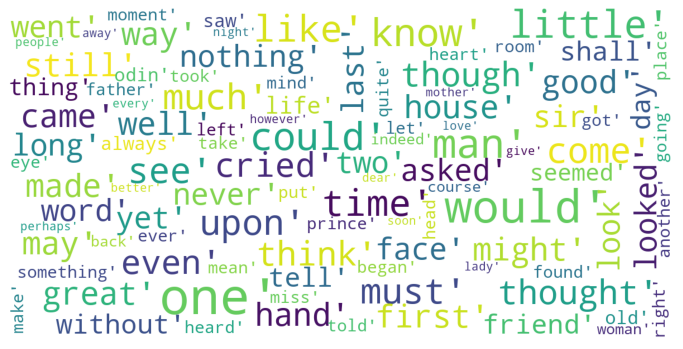

In [120]:
plot_wordcloud(lemmatized_series)